# 102 Flower Classification using ResNet50 

## 1. Prepare data

In [1]:
import os
from pathlib import Path
import scipy

### 1.1 Extracting data into train, test, and validation sets
We'll follow these steps:
1. Get the indices of labels, train, test, and validation images from the respective mat files.
2. Get the path of all the images to map the indices
3. Finally, map the indices with the list to get the respective train, test, and validation sets along with their labels.

In [2]:
# Let's load the mat files for labels and data split
labels_mat = scipy.io.loadmat('data/imagelabels.mat')
split_mat = scipy.io.loadmat('data/setid.mat')
print(f"Keys of labels mat file:\n{labels_mat.keys()}")
print(f"Keys of split mat file:\n{split_mat.keys()}")


Keys of labels mat file:
dict_keys(['__header__', '__version__', '__globals__', 'labels'])
Keys of split mat file:
dict_keys(['__header__', '__version__', '__globals__', 'trnid', 'valid', 'tstid'])


In [3]:
# Let's extract the label, train, test, and validation sets indices
labels = labels_mat['labels'].flatten() # remove that extra 1 dimension
train_idx = split_mat['trnid'].flatten()
val_idx = split_mat['valid'].flatten()
test_idx = split_mat['tstid'].flatten()

# Observe the shape to get the idea of the train, test, and validation sets sizes
print(f"Label shape: {labels.shape}")
print(f"Train data indices shape: {train_idx.shape}")
print(f"Validation data indices shape: {val_idx.shape}")
print(f"Test data indices shape: {test_idx.shape}\n")

# Let's print the indices
print(f"Labels:\n{labels[:5]}")
print(f"Train idices:\n{train_idx[:5]}")
print(f"Validation idices:\n{val_idx[:5]}")
print(f"Test idices:\n{test_idx[:5]}")



Label shape: (8189,)
Train data indices shape: (1020,)
Validation data indices shape: (1020,)
Test data indices shape: (6149,)

Labels:
[77 77 77 77 77]
Train idices:
[6765 6755 6768 6736 6744]
Validation idices:
[6773 6767 6739 6749 6763]
Test idices:
[6734 6735 6737 6742 6743]


In [4]:
# Let's see what the indices of array start from 
train_idx.min(), test_idx.min(), val_idx.min()

(28, 1, 17)

In [5]:
labels.min(), labels.max()

(1, 102)

Here, we can see the labels of images start from 1. We'll turn the labels to 0 to 101 in our custom dataset later

In [6]:
# Set the path to all the images 
image_path = Path("data/raw")

# Retrieve the paths of all the images in the dataset
image_paths = sorted(list(image_path.glob("*.jpg")))  # get all the files with '.jpg' extension
image_paths[:10], len(image_paths)

([WindowsPath('data/raw/image_00001.jpg'),
  WindowsPath('data/raw/image_00002.jpg'),
  WindowsPath('data/raw/image_00003.jpg'),
  WindowsPath('data/raw/image_00004.jpg'),
  WindowsPath('data/raw/image_00005.jpg'),
  WindowsPath('data/raw/image_00006.jpg'),
  WindowsPath('data/raw/image_00007.jpg'),
  WindowsPath('data/raw/image_00008.jpg'),
  WindowsPath('data/raw/image_00009.jpg'),
  WindowsPath('data/raw/image_00010.jpg')],
 8189)

In [7]:
# Let's split the images into train, test, and validation sets
train_images = [image_paths[i-1] for i in train_idx]  # min index is 1. So, starting with i-1
train_labels = [labels[i-1] for i in train_idx]

test_images = [image_paths[i-1] for i in test_idx]
test_labels = [labels[i-1] for i in test_idx]

val_images = [image_paths[i-1] for i in val_idx]
val_labels = [labels[i-1] for i in val_idx]

print(f"Train images length: {len(train_images)}")
print(f"Train labels length: {len(train_labels)}")

print(f"Validation images indices length: {len(val_images)}")
print(f"Validation labels length: {len(val_labels)}")

print(f"Test images length: {len(test_images)}")
print(f"Test labels length: {len(test_labels)}\n")




Train images length: 1020
Train labels length: 1020
Validation images indices length: 1020
Validation labels length: 1020
Test images length: 6149
Test labels length: 6149



### 1.2 Prepare a pytorch custom dataset
In this section, we are going to:
1. Build a custom dataset class
2. Use auto transform 
3. Make an instance of the custom dataset and apply the defined transformation

In [8]:
from torchvision import transforms

### USING AUTO TRANSFORM 
import torchvision.models as models

# Load ResNet50 with pretrained weights
weights = models.ResNet50_Weights.DEFAULT  

# Get the transformation associated with the weights
auto_transform = weights.transforms()

# 2.3 Define train transform 
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224), # Randomly resize and crop to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.ToTensor(),  # Convert the images to tensor
    transforms.Normalize(mean=auto_transform.mean, std=auto_transform.std)
])

# Define validation transform 
val_transform = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=auto_transform.mean, std=auto_transform.std)
])

In [9]:
from data_loader import ImageDataset

# Create train, test, and validation dataset
train_data = ImageDataset(train_images, train_labels, train_transform)
val_data = ImageDataset(val_images, val_labels, val_transform)
test_data = ImageDataset(test_images, test_labels, val_transform)

print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")
print(f"Validation data size: {len(val_data)}")



Train data size: 1020
Test data size: 6149
Validation data size: 1020


### 1.3 Visualize the images
Here, we'll visualize the images and compare the original images with the transformed images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2535014].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781512..2.64].


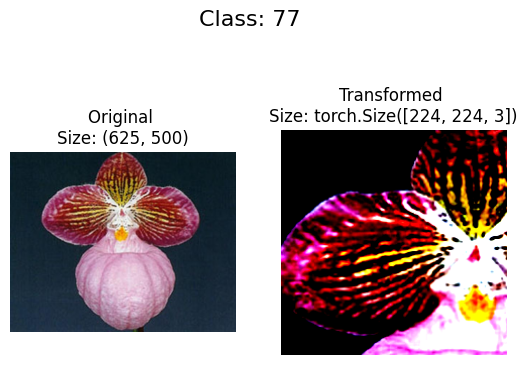

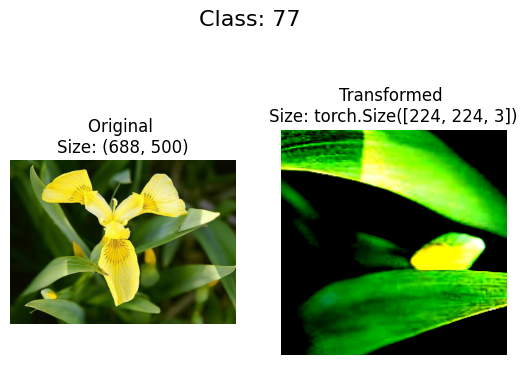

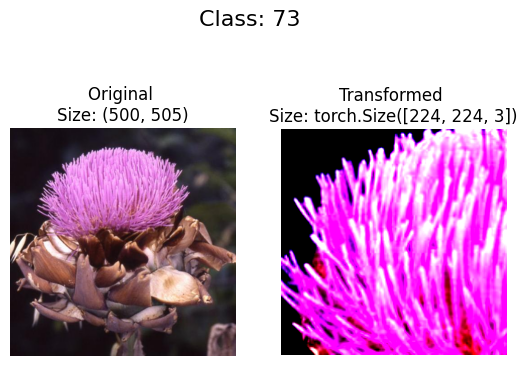

In [10]:
# Import the plot function
from utils import plot_transformed_images

# Plot the original vs transformed image
plot_transformed_images(train_images, labels, transform=train_transform, n=3)

### 1.4 Convert the datasets into DataLoaders
We'll turn our datasets into an iterator and load the images in batches instead of loading the entire dataset at once.

In [11]:
from torch.utils.data import DataLoader
import os

NUM_WORKERS = 0
BATCH_SIZE = 32
# Define train dataloader
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size= BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

# Define test dataloader
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size= BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False   # not really needed to shuffle test data
)

# Define the validation dataloader
val_dataloader = DataLoader(
    dataset=train_data,
    batch_size= BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

## 2. Training and Testing loop
1. Replace the last fully connected layer to match our number of classes i.e. 102.
2. Then freeze all the layers of the ResNet50 except the final fully conncected layer.
3. Define loss function and optimizers
4. Run the training loop.

In [12]:
import torch
from torch import nn
from torchvision import models

### 2.1 Load pretrained ResNet50 model

In [13]:
# Load teh pretrained ResNet50 model
resnet50 = models.resnet50(pretrained=True)

# Replace the last fully connected layer
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 102)

# Freeze all layers except the final fully connected layer
for param in resnet50.parameters():
    param.requires_grad = False

# Unfreeze the final layer
for param in resnet50.fc.parameters():
    param.requires_grad = True

resnet50

C:\Users\dipen\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dipen\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 2.2 Define loss and optimizer

In [14]:
# Setup device agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet50.to(device)

# Define loss funciton and optimzier
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.fc.parameters(), lr=0.001)   # only final layer


### 2.3 Training loop

In [15]:
from train import accuracy_fn, train_step, val_step
from tqdm.auto import tqdm   # for fancy progress bar :)

# Set number of epochs
NUM_EPOCHS = 10

for epoch in tqdm(range(NUM_EPOCHS)):
    train_loss, train_acc = train_step(model=resnet50,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       accuracy_fn=accuracy_fn,
                                       device=device)

    val_loss, val_acc = val_step(model=resnet50,
                                    dataloader=val_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device=device)
    
    # 4. Print out what's happening
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"val_loss: {val_loss:.4f} | "
        f"val_acc: {val_acc:.4f}")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.6665 | train_acc: 0.0734 | val_loss: 3.3854 | val_acc: 0.3256
Epoch: 2 | train_loss: 3.0182 | train_acc: 0.4279 | val_loss: 2.3265 | val_acc: 0.6057
Epoch: 3 | train_loss: 2.1555 | train_acc: 0.6310 | val_loss: 1.6178 | val_acc: 0.7504
Epoch: 4 | train_loss: 1.6302 | train_acc: 0.7302 | val_loss: 1.1528 | val_acc: 0.8246
Epoch: 5 | train_loss: 1.2594 | train_acc: 0.8098 | val_loss: 0.9300 | val_acc: 0.8778
Epoch: 6 | train_loss: 0.9962 | train_acc: 0.8521 | val_loss: 0.7611 | val_acc: 0.9023
Epoch: 7 | train_loss: 0.8682 | train_acc: 0.8597 | val_loss: 0.6785 | val_acc: 0.9062
Epoch: 8 | train_loss: 0.7614 | train_acc: 0.8855 | val_loss: 0.5595 | val_acc: 0.9188
Epoch: 9 | train_loss: 0.6799 | train_acc: 0.8873 | val_loss: 0.5264 | val_acc: 0.9159
Epoch: 10 | train_loss: 0.5874 | train_acc: 0.9000 | val_loss: 0.4442 | val_acc: 0.9354


## 3. Save and load the model to check performance on test data
1. SAVE the model
2. LOAD the model
3. TEST the model performance on the test data

### 3.1 SAVE the model

In [16]:
from pathlib import Path

### SAVING MODEL
# 1. Create saved models directory
MODEL_PATH = Path("saved_models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Giver your model a name
MODEL_NAME = "resnet50_V0"

# 3. Create the path for the model 
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 1. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=resnet50.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)


Saving model to: saved_models\resnet50_V0


### 3.2 LOAD the model

In [23]:
### LOADING MODEL
from torchvision import models 

# 1. Create an instance of the Model class
loaded_model = models.resnet50(pretrained=False)  # we don't need the pretrained weights

# Modify the fully connected (fc) layer to match your number of classes (102 for flower dataset)
num_features = resnet50.fc.in_features
loaded_model.fc = nn.Linear(num_features, 102)  # Adjusting to 102 classes

# 2. Deserialize the state_dict 
model_state_dict = torch.load("saved_models/resnet50_V0")

# 3. Apply the state_dict to the model instance
loaded_model.load_state_dict(model_state_dict)
loaded_model.to(device)


C:\Users\dipen\AppData\Local\Temp\ipykernel_17332\2120341044.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load("saved_models/resnet50_V0")


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 3.3 TEST the model performance
We'll import the evaluation function and pass the test_dataloader to the model to see how it performs on the test data_loader.py

In [26]:
from train import eval_model

loaded_model_results = eval_model(model=loaded_model,
                                  data_loader=test_dataloader,
                                  loss_fn=loss_fn,
                                  accuracy_fn=accuracy_fn,
                                  device=device)
print(loaded_model_results)

{'model_name': 'ResNet', 'model_loss': 0.732755184173584, 'model_acc': 0.8450453367875648}
